# River Time Series Extender using xfvcom
**Author: Jun Sasaki | Created: 2025-09-05 | Updated: 2025-09-07**

**Purpose:** Extend FVCOM river input time series using xfvcom's extension utilities

This notebook demonstrates xfvcom utilities for river time series extension:
- Simple one-line extension with `extend_river_nc_file()`
- Multiple extension methods (forward fill, linear, seasonal)
- Full integration with xfvcom's existing functionality
- Works with sample data or your own river NetCDF files

## 1. Setup and Imports

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Import xfvcom utilities
import xfvcom
from xfvcom import (
    extend_river_nc_file,
    read_fvcom_river_nc,
    write_fvcom_river_nc,
    extend_timeseries_ffill,
    extend_timeseries_linear,
    extend_timeseries_seasonal,
)

# Create output directory
output_dir = Path("extended_river_files")
output_dir.mkdir(exist_ok=True)

print(f"xfvcom version: {xfvcom.__version__}")
print("Setup complete")

xfvcom version: 0.2.0
Setup complete


## 2. Simple One-Line Extension and exporting to netcdf

The simplest way to extend a river NetCDF file using xfvcom:

In [2]:
# Define input and output paths
base_path = Path("~/Github/TB-FVCOM/goto2023").expanduser()
input_file = base_path / "input/2020" / "TokyoBay2020kisarazufinal_sewer.nc"

# Check if input file exists
if not input_file.exists():
    print(f"Warning: Input file not found at {input_file}")
    print("Looking for alternative river files...")
    
    # Try to find any river NC file in the notebooks directory
    local_river_files = list(Path(".").glob("*.nc"))
    if local_river_files:
        input_file = local_river_files[0]
        print(f"Found local river file: {input_file}")
    else:
        # Try the existing river.nc in notebooks directory
        if Path("river.nc").exists():
            input_file = Path("river.nc")
            print("Using existing river.nc file")
        else:
            print("\nNo river NetCDF files found.")
            print("Please provide a river NetCDF file path or create one using xfvcom CLI:")
            print("  xfvcom-make-river-nc --help")
            print("\nFor this demo, we'll use a placeholder path.")
            print("Update 'input_file' variable with your actual river NetCDF file path.")
            
            # Use a placeholder that will trigger an error if not updated
            input_file = Path("your_river_file.nc")
else:
    print(f"Input file found: {input_file}")

# Only proceed if we have a valid input file
if input_file.exists():
    # Extend the river file with one function call!
    output_ffill = output_dir / "river_extended_ffill.nc"
    
    # Forward fill extension (constant values after original data)
    extend_river_nc_file(
        input_path=input_file,
        output_path=output_ffill,
        extend_to="2022-01-01 00:00:00",
        method='ffill'
    )
    
    print(f"\nExtended file created: {output_ffill}")
else:
    print("\n⚠ Please update the input_file path to point to your river NetCDF file")

Input file found: /home/pj24001722/ku40000343/Github/TB-FVCOM/goto2023/input/2020/TokyoBay2020kisarazufinal_sewer.nc
Extended TokyoBay2020kisarazufinal_sewer.nc to 2022-01-01 00:00:00
Output saved to extended_river_files/river_extended_ffill.nc

Extended file created: extended_river_files/river_extended_ffill.nc


## 3. Different Extension Methods

xfvcom provides three extension methods:
1. **Forward Fill** - Constant values (last value repeated)
2. **Linear** - Linear extrapolation based on trend
3. **Seasonal** - Repeat seasonal patterns

Original data range: 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Number of rivers: 8
Rivers: Shibaura, Sunamachi, Ariake, Kasai, Kisarazu, AMorigasaki, BMorigasaki, CMorigasaki


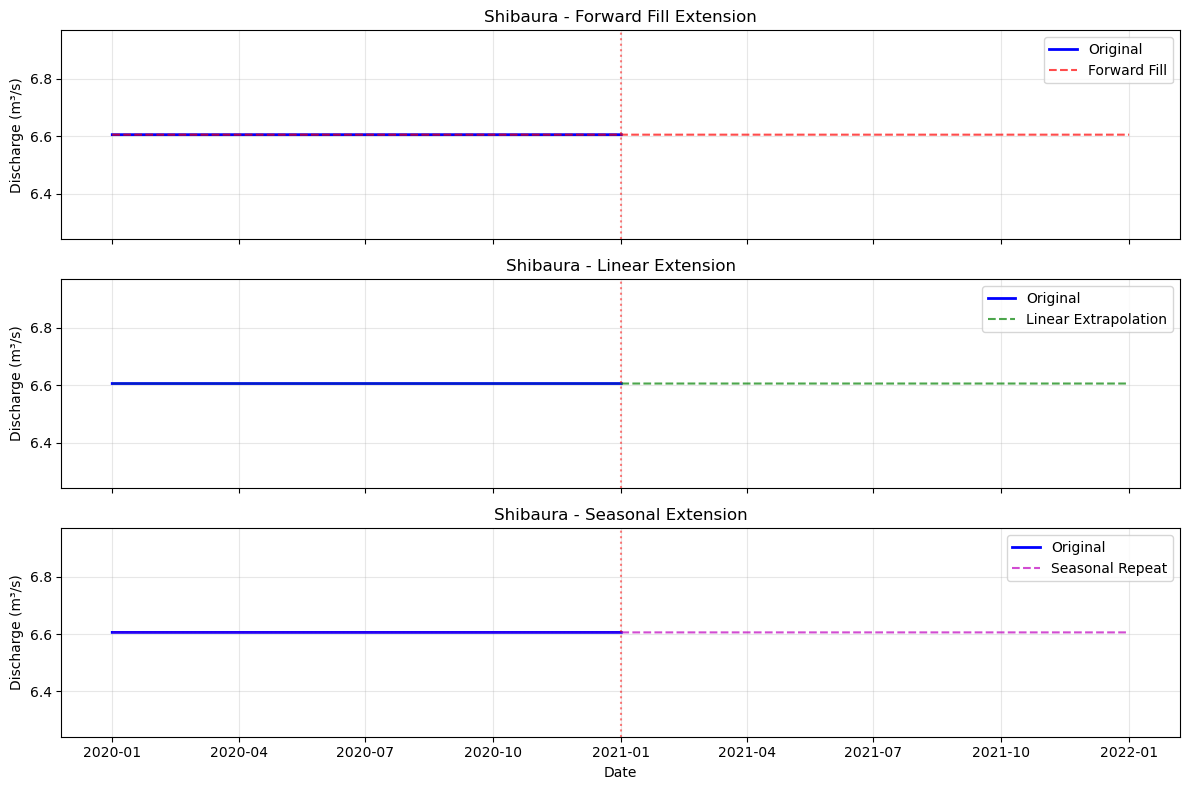

In [3]:
# Read the original data
if not input_file.exists():
    print("⚠ No input file available. Skipping this section.")
    print("Please update the input_file path in the previous cell.")
    original_data = None
else:
    original_data = read_fvcom_river_nc(input_file)
    
    print(f"Original data range: {original_data['datetime'][0]} to {original_data['datetime'][-1]}")
    print(f"Number of rivers: {len(original_data.get('river_names', []))}")
    if 'river_names' in original_data:
        print(f"Rivers: {', '.join(original_data['river_names'])}")
    
    # Demonstrate different extension methods on the first river's discharge
    if 'river_flux' in original_data:
        # Get first river's data
        river_name = original_data['river_names'][0] if 'river_names' in original_data else 'River_1'
        
        # Create figure showing different extension methods
        fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
        
        # Original data
        orig_flux = original_data['river_flux'].iloc[:, 0]
        
        # Method 1: Forward Fill
        ffill_data = extend_timeseries_ffill(
            original_data['river_flux'].iloc[:, [0]], 
            '2022-01-01 00:00:00'
        )
        axes[0].plot(orig_flux, 'b-', label='Original', linewidth=2)
        axes[0].plot(ffill_data, 'r--', label='Forward Fill', alpha=0.7)
        axes[0].set_ylabel('Discharge (m³/s)')
        axes[0].set_title(f'{river_name} - Forward Fill Extension')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Method 2: Linear Extrapolation
        linear_data = extend_timeseries_linear(
            original_data['river_flux'].iloc[:, [0]], 
            '2022-01-01 00:00:00',
            lookback_periods=60  # Use last 60 time steps for trend
        )
        axes[1].plot(orig_flux, 'b-', label='Original', linewidth=2)
        axes[1].plot(linear_data, 'g--', label='Linear Extrapolation', alpha=0.7)
        axes[1].set_ylabel('Discharge (m³/s)')
        axes[1].set_title(f'{river_name} - Linear Extension')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Method 3: Seasonal Pattern (repeat last year)
        seasonal_data = extend_timeseries_seasonal(
            original_data['river_flux'].iloc[:, [0]], 
            '2022-01-01 00:00:00',
            period='1Y'  # Repeat yearly pattern
        )
        axes[2].plot(orig_flux, 'b-', label='Original', linewidth=2)
        axes[2].plot(seasonal_data, 'm--', label='Seasonal Repeat', alpha=0.7)
        axes[2].set_ylabel('Discharge (m³/s)')
        axes[2].set_title(f'{river_name} - Seasonal Extension')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Format x-axis
        axes[-1].set_xlabel('Date')
        for ax in axes:
            ax.axvline(x=original_data['datetime'][-1], color='red', 
                       linestyle=':', alpha=0.5, label='Extension Start')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No river_flux data found in the file")

### 3.1 Interactive Plot with Plotly

In [4]:
# Create an interactive plot using xfvcom plotly utilities
try:
    from xfvcom.plot import create_river_extension_plot, print_plotly_instructions
    
    # Create the interactive comparison plot with one function call
    fig = create_river_extension_plot(
        original_data=original_data,
        extend_to='2022-01-01 00:00:00',
        river_idx=0,
        methods=['ffill', 'linear', 'seasonal'],
        height=800,
        lookback_periods=60,  # for linear method
        period='1Y'  # for seasonal method
    )
    
    # Display the plot
    fig.show()
    
    # Print interactive features guide
    print_plotly_instructions()
except ImportError:
    print("Plotly utilities not available. Install plotly with: pip install plotly")
    print("Skipping interactive plot section.")


Plotly Interactive Features:
  📍 Mouse Interactions:
    • Hover: View exact values at cursor position
    • Click & Drag: Zoom into selected area
    • Double-click: Reset view to original zoom
    • Scroll: Zoom in/out (over plot area)

  🔧 Toolbar Controls (top right):
    • Camera icon: Download plot as PNG
    • Zoom: Click and drag to zoom
    • Pan: Move around the plot
    • Box Select: Select rectangular region
    • Lasso Select: Freeform selection
    • Zoom in/out: Fixed increment zoom
    • Autoscale: Fit all data in view
    • Reset axes: Return to default view

  📊 Legend Interactions:
    • Single-click: Toggle series visibility
    • Double-click: Isolate/show all series


## 4. Advanced Usage: Custom Processing

For more control, you can read, process, and write the data separately:

In [5]:
# Read the data
data = read_fvcom_river_nc(input_file)

# Apply different extension methods to different variables
extend_to = pd.Timestamp('2022-01-01 00:00:00')

# Forward fill for discharge (conservative approach)
if 'river_flux' in data:
    data['river_flux'] = extend_timeseries_ffill(data['river_flux'], extend_to)
    print(f"Extended river_flux to {extend_to} using forward fill")

# Seasonal pattern for temperature (realistic variation)
if 'river_temp' in data:
    data['river_temp'] = extend_timeseries_seasonal(
        data['river_temp'], 
        extend_to,
        period='1Y'  # Repeat annual temperature cycle
    )
    print(f"Extended river_temp to {extend_to} using seasonal pattern")

# Forward fill for salinity (usually constant for rivers)
if 'river_salt' in data:
    data['river_salt'] = extend_timeseries_ffill(data['river_salt'], extend_to)
    print(f"Extended river_salt to {extend_to} using forward fill")

# Update datetime index
data['datetime'] = data['river_flux'].index if 'river_flux' in data else data['river_temp'].index

# Write the custom extended data
output_custom = output_dir / "river_extended_custom.nc"
write_fvcom_river_nc(output_custom, data)

print(f"\nCustom extended file created: {output_custom}")
print(f"Extended from {original_data['datetime'][0]} to {data['datetime'][-1]}")
print(f"Total time steps: {len(data['datetime'])} (added {len(data['datetime']) - len(original_data['datetime'])} steps)")

Extended river_flux to 2022-01-01 00:00:00 using forward fill
Extended river_temp to 2022-01-01 00:00:00 using seasonal pattern
Extended river_salt to 2022-01-01 00:00:00 using forward fill

Custom extended file created: extended_river_files/river_extended_custom.nc
Extended from 2020-01-01 00:00:00 to 2022-01-01 00:00:00
Total time steps: 17545 (added 8761 steps)


## 5. Batch Processing Multiple Files

Process multiple river files at once:

In [6]:
# Example: Process all river NC files in a directory
# (Uncomment and modify paths as needed)

# input_dir = Path("path/to/river/files")
# output_dir = Path("extended_files")
# output_dir.mkdir(exist_ok=True)
# 
# for nc_file in input_dir.glob("*river*.nc"):
#     output_file = output_dir / f"{nc_file.stem}_extended{nc_file.suffix}"
#     
#     try:
#         extend_river_nc_file(
#             input_path=nc_file,
#             output_path=output_file,
#             extend_to="2025-12-31 23:00:00",
#             method='ffill'
#         )
#         print(f"✓ Extended {nc_file.name}")
#     except Exception as e:
#         print(f"✗ Failed to extend {nc_file.name}: {e}")

#print("Batch processing example (commented out - modify paths as needed)")

## 6. Verification and Comparison

Compare original and extended files:

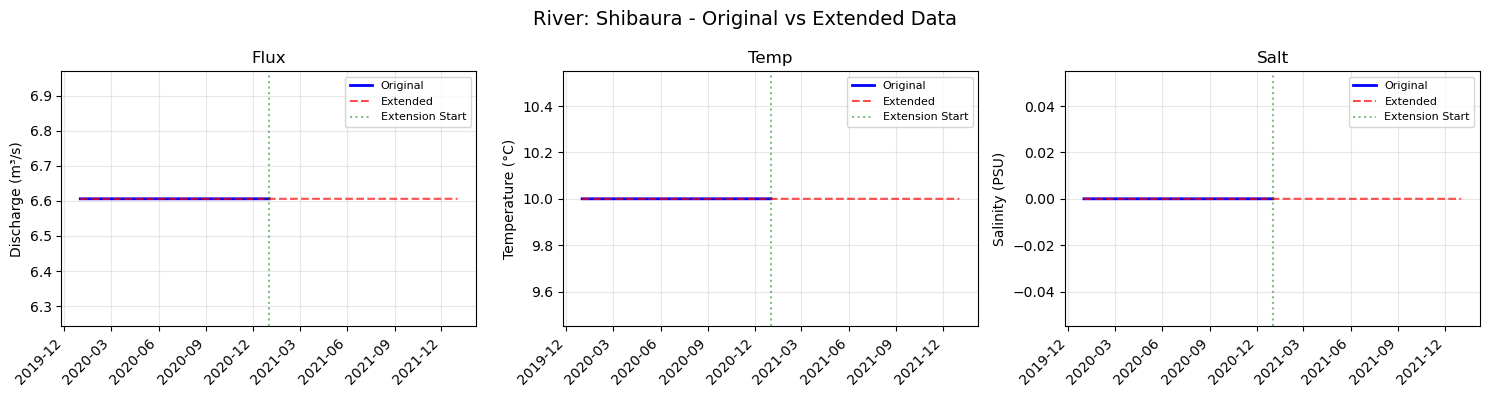


Extension Summary:
Original time range: 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Extended time range: 2020-01-01 00:00:00 to 2022-01-01 00:00:00
Original time steps: 8784
Extended time steps: 17545
Added time steps: 8761

Duration:
  Original: 366.0 days
  Extended: 731.0 days
  Added: 365.0 days (1.0 years)


In [7]:
# Read the extended file
extended_data = read_fvcom_river_nc(output_ffill)

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Select first river for visualization
river_idx = 0
river_name = original_data['river_names'][river_idx] if 'river_names' in original_data else f"River {river_idx+1}"

variables = [
    ('river_flux', 'Discharge (m³/s)', axes[0]),
    ('river_temp', 'Temperature (°C)', axes[1]),
    ('river_salt', 'Salinity (PSU)', axes[2])
]

for var_name, ylabel, ax in variables:
    if var_name in original_data:
        # Plot original
        orig = original_data[var_name].iloc[:, river_idx]
        ax.plot(orig.index, orig.values, 'b-', label='Original', linewidth=2)
        
        # Plot extended
        ext = extended_data[var_name].iloc[:, river_idx]
        ax.plot(ext.index, ext.values, 'r--', label='Extended', alpha=0.7)
        
        # Mark extension point
        ax.axvline(x=original_data['datetime'][-1], color='green', 
                   linestyle=':', alpha=0.5, label='Extension Start')
        
        ax.set_ylabel(ylabel)
        ax.set_title(var_name.replace('river_', '').title())
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=8)
        
        # Format dates on x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.suptitle(f'River: {river_name} - Original vs Extended Data', fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nExtension Summary:")
print("=" * 50)
print(f"Original time range: {original_data['datetime'][0]} to {original_data['datetime'][-1]}")
print(f"Extended time range: {extended_data['datetime'][0]} to {extended_data['datetime'][-1]}")
print(f"Original time steps: {len(original_data['datetime'])}")
print(f"Extended time steps: {len(extended_data['datetime'])}")
print(f"Added time steps: {len(extended_data['datetime']) - len(original_data['datetime'])}")

# Calculate extension duration
orig_duration = (original_data['datetime'][-1] - original_data['datetime'][0]).total_seconds() / 86400
ext_duration = (extended_data['datetime'][-1] - extended_data['datetime'][0]).total_seconds() / 86400
added_days = ext_duration - orig_duration

print("\nDuration:")
print(f"  Original: {orig_duration:.1f} days")
print(f"  Extended: {ext_duration:.1f} days")
print(f"  Added: {added_days:.1f} days ({added_days/365:.1f} years)")

## 7. Data Integrity Check

Verify that the original data is preserved and extension is applied correctly:

In [8]:
import numpy as np

# Check data integrity
print("Data Integrity Check")
print("=" * 50)

# Check if original portion is preserved
orig_len = len(original_data['datetime'])
integrity_ok = True

for var_name in ['river_flux', 'river_temp', 'river_salt']:
    if var_name in original_data and var_name in extended_data:
        orig_values = original_data[var_name].values
        ext_values = extended_data[var_name].values[:orig_len]
        
        if np.allclose(orig_values, ext_values, rtol=1e-6, atol=1e-8, equal_nan=True):
            print(f"✓ {var_name}: Original data preserved correctly")
        else:
            print(f"✗ {var_name}: Data mismatch detected!")
            integrity_ok = False
            
            # Find where differences occur
            diff_mask = ~np.isclose(orig_values, ext_values, rtol=1e-6, atol=1e-8)
            if diff_mask.any():
                diff_indices = np.where(diff_mask)
                print(f"  Differences at indices: {diff_indices}")

# Check forward fill (for ffill method)
if output_ffill.exists():
    print("\nForward Fill Verification:")
    for var_name in ['river_flux', 'river_temp', 'river_salt']:
        if var_name in extended_data:
            # Get last original value and extended values
            last_orig = extended_data[var_name].iloc[orig_len-1, :]
            extended_portion = extended_data[var_name].iloc[orig_len:, :]
            
            # Check if all extended values match the last original value
            all_match = True
            for col in extended_data[var_name].columns:
                if not np.all(extended_portion[col] == last_orig[col]):
                    all_match = False
                    break
            
            if all_match:
                print(f"✓ {var_name}: Forward fill applied correctly")
            else:
                print(f"✗ {var_name}: Forward fill may have issues")

if integrity_ok:
    print("\n✓ All integrity checks passed!")
else:
    print("\n✗ Some integrity checks failed. Please review the data.")

Data Integrity Check
✓ river_flux: Original data preserved correctly
✓ river_temp: Original data preserved correctly
✓ river_salt: Original data preserved correctly

Forward Fill Verification:
✓ river_flux: Forward fill applied correctly
✓ river_temp: Forward fill applied correctly
✓ river_salt: Forward fill applied correctly

✓ All integrity checks passed!


## Summary

This notebook demonstrated the new xfvcom utilities for river time series extension:

### Key Features:
1. **Simple one-line extension**: `extend_river_nc_file()`
2. **Multiple methods**: Forward fill, linear extrapolation, seasonal patterns
3. **Preserves FVCOM format**: Uses netCDF4 directly, maintains all attributes
4. **Flexible processing**: Can handle each variable differently
5. **Batch capable**: Process multiple files easily
6. **Interactive visualization**: New plotly utilities for time series comparison

### New xfvcom Functions:

#### Time Series Extension:
- `extend_river_nc_file()` - High-level extension function
- `read_fvcom_river_nc()` - Read river NetCDF files
- `write_fvcom_river_nc()` - Write FVCOM-compatible NetCDF
- `extend_timeseries_ffill()` - Forward fill extension
- `extend_timeseries_linear()` - Linear extrapolation
- `extend_timeseries_seasonal()` - Seasonal pattern repetition

#### Interactive Plotting (new):
- `create_river_extension_plot()` - One-line river extension visualization
- `plot_timeseries_comparison()` - General time series comparison plot
- `plot_timeseries_multi_variable()` - Multi-variable time series plot
- `print_plotly_instructions()` - Display interactive features guide

### Usage Examples:
```python
# Simple extension
extend_river_nc_file('input.nc', 'output.nc', '2025-12-31', method='ffill')

# Custom processing
data = read_fvcom_river_nc('input.nc')
data['river_flux'] = extend_timeseries_ffill(data['river_flux'], '2025-12-31')
write_fvcom_river_nc('output.nc', data)

# Interactive visualization (new)
from xfvcom.plot import create_river_extension_plot
fig = create_river_extension_plot(
    original_data=data,
    extend_to='2025-12-31',
    methods=['ffill', 'linear', 'seasonal']
)
fig.show()
```

These utilities are now part of xfvcom and can be imported directly:
```python
from xfvcom import extend_river_nc_file
from xfvcom.plot import create_river_extension_plot  # New plotly utilities
```